### Intro

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

### Voting Classifiers

* Good classifiers can be built by aggregating predictions of various *weaker* classifiers, and returning the class that gets the most votes. (A "hard voting" classifier.)

In [2]:
heads_proba = 0.51
coin_tosses = (rnd.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(
    coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
#cumulative_heads_ratio

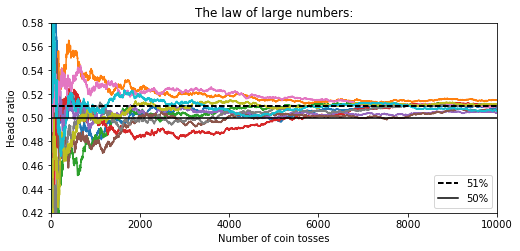

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.title("The law of large numbers:")
plt.axis([0, 10000, 0.42, 0.58])
#save_fig("law_of_large_numbers_plot")
plt.show()

In [4]:
# build a voting classifier in Scikit using three weaker classifiers

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# use moons dataset
X, y = make_moons(
    n_samples=500, 
    noise=0.30, 
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# voting classifier = logistic + random forest + SVC

voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft'
    )
voting_clf.fit(X_train, y_train)

# let's see how each individual classifier did:

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
# voting classifier did better than 3 individual ones!

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


* If all classifiers can estimate class probabilities (they have a predict_proba() method), use Scikit to predict highest class probability, averaged over all individual classifiers. (*soft voting*)

* Often better than hard voting because it gives more weight to highly confident votes. Replace voting="hard" with "soft" & ensure all classifiers can estimate class probabilities. (SVC cannot by default -set probability param to True.)

* This tells SVC to use cross-validation to estimate class probabilities. Slows training times & adds a predict_proba() method).

### Bagging & Pasting

* Another approach: use same training algorithm, but apply it to different subsets of the training dataset.
* **bagging**: sampling the dataset **with** replacement.
* **pasting**: sampling the dataset **without** replacement.
* Final prediction = based on an aggregation function.
* Predictions can be made in parallel -- good scaling properties.

In [5]:
from sklearn.datasets import make_moons
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Train ensemble of 500 Decision Tree classifiers
# each using 100 training instances - randomly sampled from training set
# with replacement.

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, # set to False for pasting instead of bagging.
    n_jobs=-1, 
    random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


In [6]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [7]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

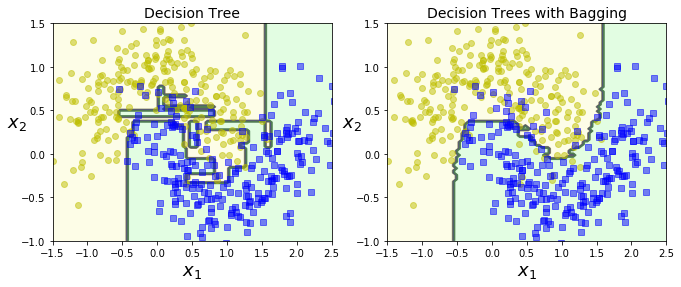

In [8]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out of Bag Evaluation
* Bagging: some instances may be sampled multiple times - others not at all. On avg, ~63% of training samples are used. Remainder 37% = "out of bag".
* use *oob_score=True* in Scikit to do automatic oob evaluation after training.

In [9]:
# oob_score_: predicts classifier results on test set.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.89866666666666661

In [10]:
# did oob_score_ do a good job?
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.90400000000000003

In [11]:
# oob decision functionfor each training instance
bag_clf.oob_decision_function_

array([[ 0.36363636,  0.63636364],
       [ 0.38586957,  0.61413043],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.06632653,  0.93367347],
       [ 0.30769231,  0.69230769],
       [ 0.03015075,  0.96984925],
       [ 0.99444444,  0.00555556],
       [ 0.94708995,  0.05291005],
       [ 0.79      ,  0.21      ],
       [ 0.00507614,  0.99492386],
       [ 0.77456647,  0.22543353],
       [ 0.84269663,  0.15730337],
       [ 0.95480226,  0.04519774],
       [ 0.06557377,  0.93442623],
       [ 0.        ,  1.        ],
       [ 0.98      ,  0.02      ],
       [ 0.95505618,  0.04494382],
       [ 1.        ,  0.        ],
       [ 0.01086957,  0.98913043],
       [ 0.3372093 ,  0.6627907 ],
       [ 0.89949749,  0.10050251],
       [ 1.        ,  0.        ],
       [ 0.96666667,  0.03333333],
       [ 0.        ,  1.        ],
       [ 0.99375   ,  0.00625   ],
       [ 1.        ,  0.        ],
       [ 0.        ,

### Random Patches - Random Subspaces

* **BaggingClassifier** supports feature sampling. Params: *max_features* and *bootstrap*. 
* Very useful when handling high-dimensional datasets.
* "Random patches": sampling features & sampling instances.
* "Random subspaces": sampling features & keeping all instances.

### Random Forests
* RF = ensemble of Decision Trees
* Typically trained via bagging
* **RandomForestClassifier**: designed for DT classification
* **RandomForestRegressor**: designed for regression

In [12]:
# Train an RF classifier with 500 trees limited to 16 max nodes each.
# splitter="random": tells RF to search for best feature among
# a random subset of features.

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(
        splitter="random", 
        max_leaf_nodes=16, 
        random_state=42),
    
    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True,
    n_jobs=-1,
    random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    max_leaf_nodes=16, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [14]:
# almost identical predictions
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.97599999999999998

### Feature importance
* important features likely to appear closer to root of tree
* unimportant features likely to appear closer to leaves - if at all.
* Scikit finds avg depth of feature appearance across all trees in an RF.

In [15]:
# rank features by importance in iris
# #1: petal length: 44%

from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    n_jobs=-1, 
    random_state=42)

rnd_clf.fit(iris["data"], iris["target"])

for name, importance in zip(
    iris["feature_names"], 
    rnd_clf.feature_importances_):
        print(name, "=", importance)

sepal length (cm) = 0.112492250999
sepal width (cm) = 0.0231192882825
petal length (cm) = 0.441030464364
petal width (cm) = 0.423357996355


In [16]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

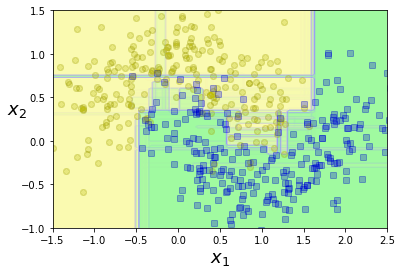

In [17]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(
        max_leaf_nodes=16, 
        random_state=42+i)
    
    indices_with_replacement = rnd.randint(
        0, 
        len(X_train), 
        len(X_train))
    
    tree_clf.fit(
        X[indices_with_replacement], 
        y[indices_with_replacement])
    
    plot_decision_boundary(
        tree_clf, X, y, 
        axes=[-1.5, 2.5, -1, 1.5], 
        alpha=0.02, 
        contour=False)

plt.show()

### Boosting - AdaBoost
* One strategy: pay more attention to training instances that predecessor underfitted - forces new predictors to concentrate more on the "hard cases".
* **Disadvantage**: results depend on previous classifier (sequential), so algo cannot be parallelized. Not great for scaling.

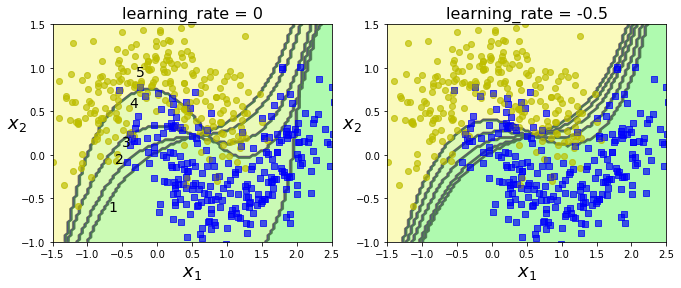

In [18]:
# Plot decision boundaries of five predictors on moons dataset

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        
        svm_clf = SVC(
            kernel="rbf", 
            C=0.05)
        
        svm_clf.fit(
            X_train, y_train, 
            sample_weight=sample_weights)
        
        y_pred = svm_clf.predict(
            X_train)
        
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        
        plot_decision_boundary(
            svm_clf, 
            X, y, 
            alpha=0.2)
        
        plt.title("learning_rate = {}".format(learning_rate - 1), 
                  fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
#save_fig("boosting_plot")
plt.show()

# left: 1st clf gets many wrong, so 2nd clf gets boosted values.
# right: same sequence, but learning rate cut in half.

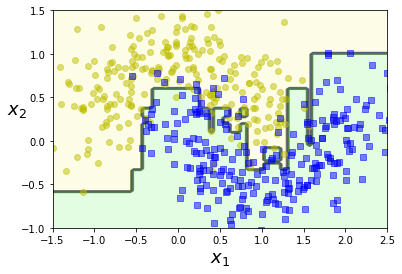

In [19]:
# train AdaBoost classifier on 200 decision stumps (DS)
# DS = decision tree with max_depth=1

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.5, random_state=42
    )
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)
plt.show()

### Boosting - Gradient Boosting
* Similar to AdaBoost (continually correcting the predecessors in an ensemble. Instead of tweaking instance weights on each iteration, GB fits the predictor to the *residual errors* of the previous predictor.

In [20]:
from sklearn.tree import DecisionTreeRegressor

# training set: a noisy quadratic function
rnd.seed(42)
X = rnd.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * rnd.randn(100)

# train Regressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# now train 2nd Regressor using errors made by 1st one.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# now train 3rd Regressor using errors made by 2nd one.
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

X_new = np.array([[0.8]])

# now have ensemble w/ three trees.
y_pred = sum(tree.predict(X_new) for tree in (
    tree_reg1, tree_reg2, tree_reg3))

print(y_pred)

[ 0.75026781]


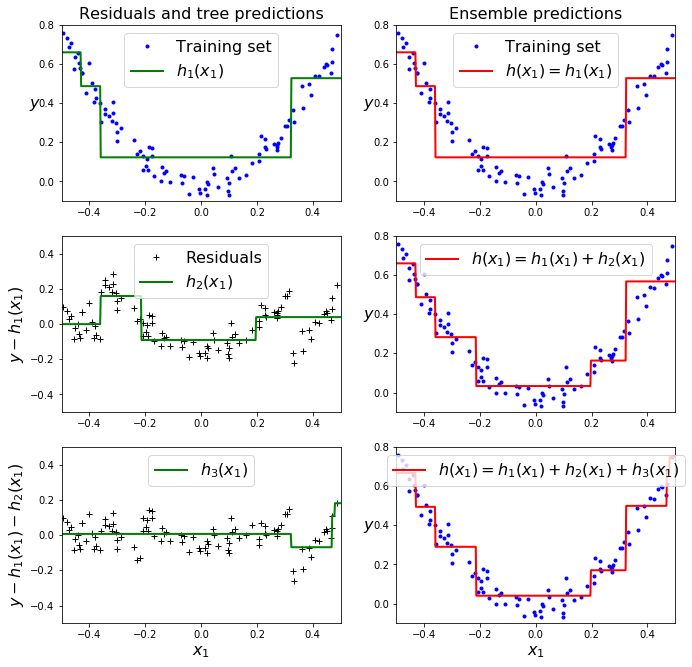

In [21]:
def plot_predictions(
    regressors, X, y, axes, 
    label=None, 
    style="r-", 
    data_style="b.", 
    data_label=None):
    
    x1 = np.linspace(axes[0], axes[1], 500)
    
    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
            
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

# 1st row: ensemble = only one tree: predictions match 1st tree.
# 2nd row: new tree trained on residual errors of 1st tree.
# 3rd row: "                                              "
# result: ensemble predictions get better as trees are added.

* *learning_rate* param controls contribution of each tree. Low values (ex: 0.1) = need more trees in ensemble to fit training set, but predictions usually generalize better. (This is called **shrinkage**.)

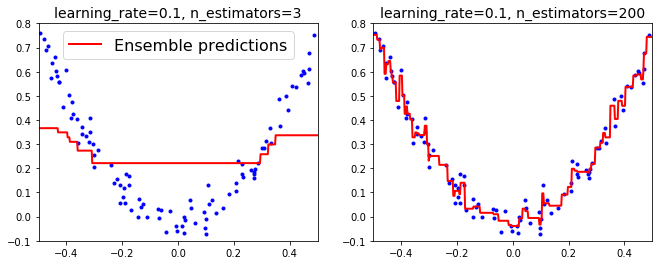

In [22]:
# two GBRT ensembles trained with low learning rate

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=0.1, 
    random_state=42)

gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=200, 
    learning_rate=0.1, 
    random_state=42)

gbrt_slow.fit(X, y)

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions(
    [gbrt], X, y, 
    axes=[-0.5, 0.5, -0.1, 0.8], 
    label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions(
    [gbrt_slow], X, y, 
    axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

#save_fig("gbrt_learning_rate_plot")
plt.show()

# left: not enough trees (underfits)
# right: too many trees (overfits)

* To find optimal number of trees - use early stopping method.
* *staged_predict* method: returns iterator

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

# train GRBR regressor with 120 trees

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=120, 
    learning_rate=0.1, 
    random_state=42)

gbrt.fit(X_train, y_train)

# measure MSE validation error at each stage
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
errors

[0.05877146809545241,
 0.050146609664278821,
 0.042693525239940654,
 0.036758764317358611,
 0.032342621749728441,
 0.028407668512271105,
 0.024897554253370889,
 0.022344405311247584,
 0.019535997367701449,
 0.017423553892941333,
 0.015298227412102105,
 0.013614891608372095,
 0.01241865401978786,
 0.01114950733723946,
 0.010131360091843384,
 0.0091854704682465919,
 0.0085684302891776056,
 0.0078525358395017328,
 0.0072105819722258777,
 0.0067708705683962693,
 0.0062415649764643415,
 0.0058360573276457243,
 0.0053862983457847987,
 0.0051345071507873903,
 0.0048692096567381805,
 0.0045993749990593299,
 0.0043550054844811968,
 0.0041542481413648245,
 0.0039794595160053785,
 0.0038058301746231277,
 0.0036528925611761264,
 0.0035903310836105469,
 0.0035078898256137104,
 0.0034145667924260869,
 0.0033091498103360911,
 0.0032216349333429491,
 0.0031684358902285465,
 0.0031067035318094903,
 0.0030811367114601672,
 0.0030602631146299077,
 0.003000040093686018,
 0.0029246869254349805,
 0.00285593

In [24]:
# train another GBRT ensemble using optimal #trees

best_n_estimators = np.argmin(errors)
min_error = errors[best_n_estimators]

gbrt_best = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=best_n_estimators, 
    learning_rate=0.1, 
    random_state=42)

gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=79, presort='auto',
             random_state=42, subsample=1.0, verbose=0, warm_start=False)

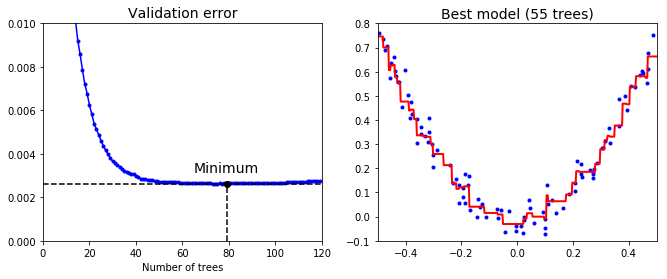

In [25]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (55 trees)", fontsize=14)

#save_fig("early_stopping_gbrt_plot")
plt.show()

* Another method: actually stopping training early
* Implement via *warm_start=True* (tells Scikit to keep existing trees when fit() is called - allowing incremental training.)

In [26]:
gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=1, 
    learning_rate=0.1, 
    random_state=42, 
    warm_start=True)

min_val_error = float("inf")
error_going_up = 0

# 120 estimators.
# stop training with validation error doesn't improve for
# five consecutive iterations

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)

    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping
            
print(gbrt.n_estimators)

59


### Stacking
* Instead of using a voting function to aggregate an ensemble's predictor outputs, instead train a model to do the aggregation. ("blending".)
* Blender training: common approach = use a *holdout set*.

In [27]:
# todo: stacking implementation